In [1]:
import skfem
from skfem.models.poisson import laplace
from skfem.helpers import grad
import numpy as np

<AxesSubplot:title={'center':'triangle mesh'}>

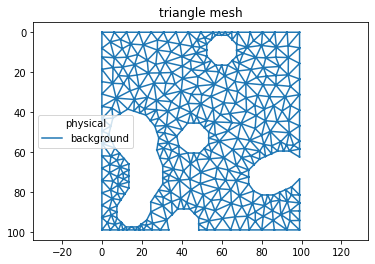

In [2]:
import numpy as np
from skimage.morphology import disk
from nanomesh.data import binary_blobs2d

data = binary_blobs2d(length=100, seed=96)

from nanomesh import Mesher

mesher = Mesher(data)
mesher.generate_contour(max_edge_dist=3, precision=1)
mesh = mesher.triangulate(opts='q30a25')
triangles = mesh.get('triangle')
triangles.purge(label=2, key='physical')
triangles.plot()

[0. 0.] [99. 99.]


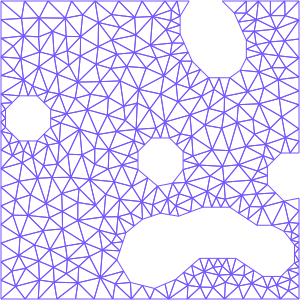

In [3]:
p = triangles.points.T
t = triangles.cells.T

print(p.min(axis=1), p.max(axis=1))

m = skfem.MeshTri(np.ascontiguousarray(p), np.ascontiguousarray(t))
m

In [4]:
from skfem import *
from skfem.helpers import grad, dot, jump
from skfem.models.poisson import laplace, unit_load

e = ElementTriDG(ElementTriP4())
alpha = 1e-3

ib = Basis(m, e)
bb = FacetBasis(m, e)
fb = [InteriorFacetBasis(m, e, side=i) for i in [0, 1]]

@BilinearForm
def dgform(u, v, p):
    ju, jv = jump(p, u, v)
    h = p.h
    n = p.n
    return ju * jv / (alpha * h) - dot(grad(u), n) * jv - dot(grad(v), n) * ju

@BilinearForm
def nitscheform(u, v, p):
    h = p.h
    n = p.n
    return u * v / (alpha * h) - dot(grad(u), n) * v - dot(grad(v), n) * u

A = asm(laplace, ib)
B = asm(dgform, fb, fb)
C = asm(nitscheform, bb)
b = asm(unit_load, ib)

x = solve(A + B + C, b)

M, X = ib.refinterp(x, 4)

Initializing CellBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing BoundaryFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'dgform'.
Assembling finished.
Assembling 'nitscheform'.
Assembling finished.
Assembling 'unit_load'.
Assembling finished.
Solving linear system, shape=(9225, 9225).
Solving done.


<AxesSubplot:>

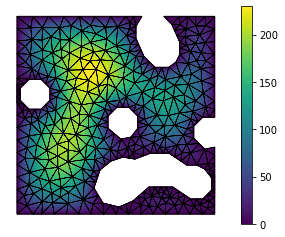

In [5]:
def visualize():
    from skfem.visuals.matplotlib import plot, draw
    ax = draw(M, boundaries_only=True)
    return plot(M, X, shading="gouraud", ax=ax, colorbar=True)

visualize()